# Create a Dataset for Sentiment Analysis

In this notebook, I will be collecting the data to build a sentiment analysis model using BERT. I will be collecting the data from the google play store by building custom scrappers.

## The Goal of the Dataset

I want to collect almost similar number of positive and negative reviews to build a robust model. We can scrape app info and reviews using the [google-play-scraper](https://github.com/JoMingyu/google-play-scraper) package.

## Setup

Let's install the required packages and setup the imports:

In [2]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Let's choose some apps that fit the criteria from the *Productivity* category. We'll use [AppAnnie](https://www.appannie.com/apps/google-play/top-chart/?country=US&category=29&device=&date=2020-04-05&feed=All&rank_sorting_type=rank&page_number=1&page_size=100&table_selections=) to select some of the top US apps:

In [3]:
# List of app and their packages to be collected 
app_packages = [
  'com.anydo',
  'com.todoist',
  'com.ticktick.task',
  'com.habitrpg.android.habitica',
  'cc.forestapp',
  'com.oristats.habitbull',
  'com.levor.liferpgtasks',
  'com.habitnow',
  'com.microsoft.todos',
  'prox.lab.calclock',
  'com.gmail.jmartindev.timetune',
  'com.artfulagenda.app',
  'com.tasks.android',
  'com.appgenix.bizcal',
  'com.appxy.planner'
]

## Scraping App Information

Let's scrape the info for each app:

In [4]:
app_infos = []

for ap in tqdm(app_packages):
    info = app(ap, lang='en', country='us')
    del info['comments']
    app_infos.append(info)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.80it/s]


We got the info for all 15 apps. Let's write a helper function that prints JSON objects a bit better:

In [5]:
def print_json(json_object):
    json_str = json.dumps(
        json_object, 
        indent=2, 
        sort_keys=True, 
        default=str
    )
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

Here is a sample app information from the list:

In [6]:
print_json(app_infos[0])

{
  "adSupported": null,
  "androidVersion": "Varies",
  "androidVersionText": "Varies with device",
  "appId": "com.anydo",
  "containsAds": false,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "<b>\ud83c\udfc6 Editor's Choice by Google</b>\r\n\r\nAny.do is a To Do List, Calendar, Planner, Tasks & Reminders App That Helps Over 25M People Stay Organized and Get More Done.\r\n\r\n<b>\ud83e\udd47 \"A MUST HAVE APP\" (Lifehacker, NYTimes, USA TODAY, WSJ).</b>\r\n\r\nAny.do is a free to-do list, planner & calendar app for managing and organizing your daily tasks, to-do lists, notes, reminders, checklists, calendar events, grocery lists and more.\r\n\r\n\ud83d\udcc5 Organize Your Tasks & To-Do List in Seconds\r\n\r\n\u2022 ADVANCED CALENDAR & DAILY PLANNER - Keep your to-do list and calendar events always at hand with our calendar widget. Any.do to-do list & planner support daily calendar view, 3-day Calendar view, Weekly calendar v

This contains lots of information including the number of ratings, number of reviews and number of ratings for each score (1 to 5). We can select what is relevant and even some of the info we like. For example, we can print all their logos. 

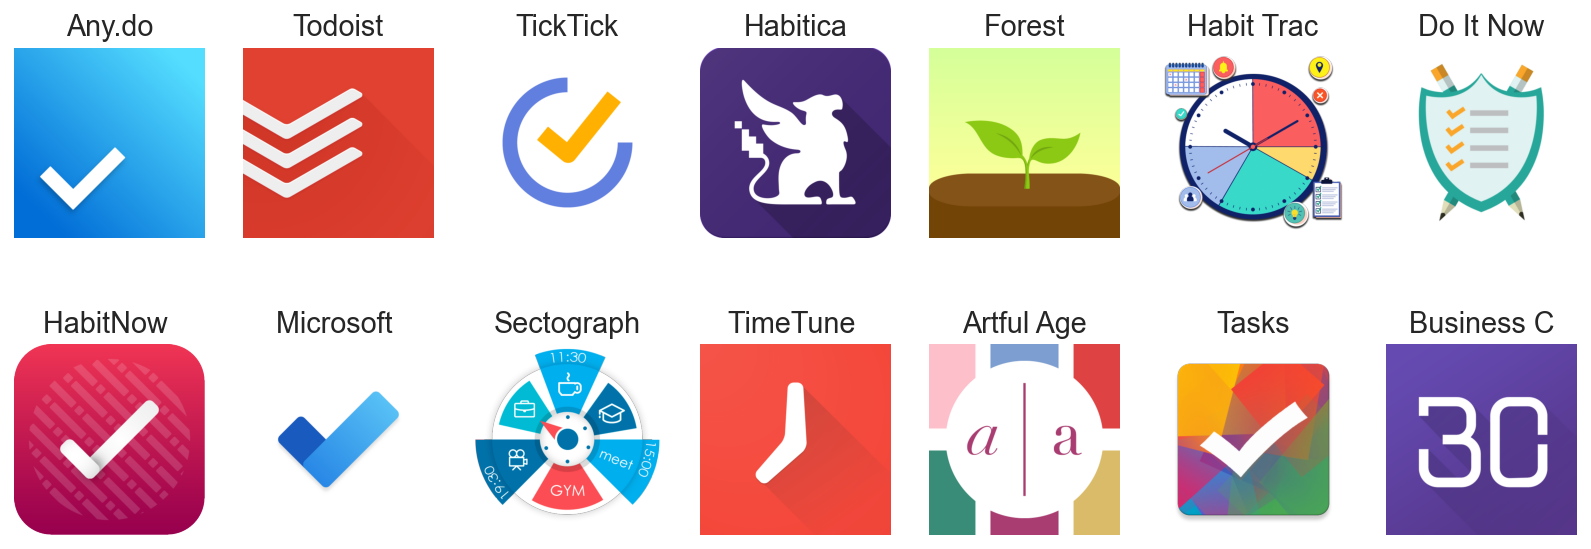

In [7]:
# Function to format and get the title
def format_title(title):
    sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
    
    if sep_index != -1:
        title = title[:sep_index]
    return title[:10]

# Print logos and titles
fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
    ai = app_infos[i]
    img = plt.imread(ai['icon'])
    ax.imshow(img)
    ax.set_title(format_title(ai['title']))
    ax.axis('off')

We'll store the app information for later by converting the JSON objects into a Pandas dataframe and saving the result into a CSV file:

In [8]:
# App Data into Pandas DF and store it
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('../data/apps.csv', index=None, header=True)

## Scraping App Reviews

In an ideal world, we would get all the reviews. But there are lots of them and we're scraping the data. That wouldn't be very polite. What should we do?

We want:

- Balanced dataset - roughly the same number of reviews for each score (1-5)
- A representative sample of the reviews for each app

We can satisfy the first requirement by using the scraping package option to filter the review score. For the second, we'll sort the reviews by their helpfulness, which are the reviews that Google Play thinks are most important. Just in case, we'll get a subset from the newest, too:

In [14]:
app_reviews = []

# Loop through all the app packages and collect review for each of them
for ap in tqdm(app_packages):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='en',
                country='us',
                sort=sort_order,
                count= 150 if score == 3 else 200,
                filter_score_with=score
            )
        for r in rvs:
            r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
            r['appId'] = ap

        app_reviews.extend(rvs)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:36<00:00, 10.40s/it]


Note that we're adding the app id and sort order to each review. Here's an example for one:

In [15]:
print_json(app_reviews[0])

{
  "appId": "com.anydo",
  "at": "2020-10-27 21:24:41",
  "content": "I cannot open the app anymore",
  "repliedAt": null,
  "replyContent": null,
  "reviewCreatedVersion": "5.4.0.6",
  "reviewId": "gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-fgH355YH_t7J2q4xYo6ZzN3Mc7iSrrTV6ke8hG_fl4Q",
  "score": 1,
  "sortOrder": "newest",
  "thumbsUpCount": 0,
  "userImage": "https://play-lh.googleusercontent.com/a-/AOh14GiGET2XHTvsSEsA07ZBPu2s1E6fOXd9WyT_ahChpw",
  "userName": "Eric Tie"
}



`repliedAt` and `replyContent` contain the developer response to the review. Of course, they can be missing.

How many app reviews did we get?



In [16]:
print("We were able to scrap: ", len(app_reviews), " reviews")

We were able to scrap:  12495  reviews


Let's save the reviews to a CSV file:

In [17]:
# Save app reviews in a CSV format
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('../data/reviews.csv', index=None, header=True)

In [18]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,None,NaT,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,None,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,None,2020-10-27 08:18:40,None,NaT,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,None,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,None,NaT,newest,com.anydo


## References

- [Google Play Scraper for Python](https://github.com/JoMingyu/google-play-scraper)